<a href="https://colab.research.google.com/github/escuccim/pytorch-face-autoencoder/blob/master/eas7_faces_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adding some longer residual connections to try to preserve some small details which seem to be getting lost; added batch norm; replaced 6x5 convolution with global average pool followed by 1x1 convolution.

In [0]:
import torch
import torchvision
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
%matplotlib inline
import zipfile
import os

In [0]:
from google.colab import auth
auth.authenticate_user()

In [3]:
# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud alpha survey



In [4]:
!gsutil cp gs://{bucket_name}/model_31.pt ./model_3.pt 

Copying gs://pneumonia/model_31.pt...
- [1 files][294.9 MiB/294.9 MiB]                                                
Operation completed over 1 objects/294.9 MiB.                                    


In [5]:
if not os.path.exists("celeba-dataset.zip"):
#   !kaggle datasets download -d jessicali9530/celeba-dataset
  !gsutil cp gs://{bucket_name}/celeba-dataset.zip ./celeba-dataset.zip
  zip_ref = zipfile.ZipFile('celeba-dataset.zip', 'r')
  zip_ref.extractall('data')
  zip_ref.close()

  zip_ref = zipfile.ZipFile('data/img_align_celeba.zip', 'r')
  zip_ref.extractall('data/images')
  zip_ref.close()

Copying gs://pneumonia/celeba-dataset.zip...
/ [1 files][  1.2 GiB/  1.2 GiB]  102.4 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


In [6]:
if not os.path.exists("Training_Pictures.zip"):
  !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
  zip_ref = zipfile.ZipFile('Training_Pictures.zip', 'r')
  zip_ref.extractall('data/images')
  zip_ref.close()
  
# if not os.path.exists("GWB_200x200_JPEG.zip"):
#   !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/GWB_200x200_JPEG.zip
#   zip_ref = zipfile.ZipFile('GWB_200x200_JPEG.zip', 'r')
#   zip_ref.extractall('data/images')
#   zip_ref.close()  

--2019-05-14 05:26:58--  https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
Resolving s3.eu-west-3.amazonaws.com (s3.eu-west-3.amazonaws.com)... 52.95.154.33
Connecting to s3.eu-west-3.amazonaws.com (s3.eu-west-3.amazonaws.com)|52.95.154.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1073596 (1.0M) [application/zip]
Saving to: ‘Training_Pictures.zip’

Training_Pictures.z 100%[===================>]   1.02M  2.05MB/s    in 0.5s    

2019-05-14 05:26:59 (2.05 MB/s) - ‘Training_Pictures.zip’ saved [1073596/1073596]



In [7]:
if not os.path.exists("wiki_images2.zip"):
  !gsutil cp gs://{bucket_name}/wiki_images2.zip ./wiki_images.zip
  zip_ref = zipfile.ZipFile('wiki_images.zip', 'r')
  zip_ref.extractall('data/images')
  zip_ref.close()
  
if not os.path.exists("imdb_images3.zip"):
  !gsutil cp gs://{bucket_name}/imdb_images3.zip ./imdb_images3.zip
  zip_ref = zipfile.ZipFile('imdb_images3.zip', 'r')
  zip_ref.extractall('data/images')
  zip_ref.close()    

Copying gs://pneumonia/wiki_images2.zip...
| [1 files][160.5 MiB/160.5 MiB]                                                
Operation completed over 1 objects/160.5 MiB.                                    
Copying gs://pneumonia/imdb_images3.zip...
\ [1 files][  1.5 GiB/  1.5 GiB]   88.7 MiB/s                                   
Operation completed over 1 objects/1.5 GiB.                                      


In [0]:
BATCH_SIZE = 48
data_path = "data/images"

transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5), 
      torchvision.transforms.RandomApply([
        torchvision.transforms.RandomAffine(degrees=5, translate=(0.05,0.05), scale=(0.9,1.1), shear=2, resample=False, fillcolor=0),        
      ], 0.4),
      torchvision.transforms.RandomResizedCrop((192,160), scale=(0.90, 1.1)),
      torchvision.transforms.ToTensor(),
    ])

train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transform
    )

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=True
)

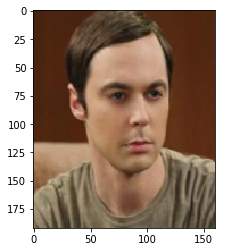

In [9]:
for (images, _) in train_loader:
  plt.imshow(images[0].permute(1,2,0))
  plt.show()
  break

In [10]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 393640
    Root Location: data/images
    Transforms (if any): Compose(
                             RandomHorizontalFlip(p=0.5)
                             RandomApply(
                             p=0.4
                             RandomAffine(degrees=(-5, 5), translate=(0.05, 0.05), scale=(0.9, 1.1), shear=(-2, 2))
                         )
                             RandomResizedCrop(size=(192, 160), scale=(0.9, 1.1), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                         )
    Target Transforms (if any): None

In [0]:
def output_size(i, k=3, p=2, s=1, d=1):
    o = (i + 2*p - k - (k-1)*(d-1))/s + 1
    return o
  
output_size(i=64, k=3, p=1)

### Bigger Model

In [0]:
epoch_list = []

In [0]:
def vae_loss(x, x_hat, mu=None, logvar=None):
    MSE = nn.functional.mse_loss(x, x_hat)
    
    if mu is not None and logvar is not None:
      KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
      KLD /= BATCH_SIZE * 784
      MSE = MSE + KLD
      
    return MSE
  
def train(model, train_loader, optimizer, print_metrics=1000, plot_images=4000, num_epochs=10, display_images=5, scheduler=None, save_path="model_3.pt"):
    model.train()
    try:
      for epoch in range(num_epochs):
          upload_path = save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 
          
          tr_loss = 0.0
          batch_losses = []
          for i, (inputs, _) in enumerate(train_loader):
              if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()

              optimizer.zero_grad()

              recon, code, logvar = model(inputs)
              if model.variational:
                  loss = vae_loss(inputs, recon, code, logvar=logvar)
              else:  
                  loss = vae_loss(inputs, recon, code, logvar=None)

              loss.backward()
              optimizer.step()

              tr_loss += loss.item()
              batch_losses.append(loss.item())
            
              if i > 0 and print_metrics != 0 and i % print_metrics == 0:
                print("\tEpoch", len(epoch_list), "batch", i, "loss:", loss.item())

              if i % plot_images == 0 and i > 0:
                fig, ax = plt.subplots(1, 2, figsize=(6,6))
                ax[0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                plt.show()

          print("Epoch:", len(epoch_list), "Loss:", tr_loss)
          
          epoch_list.append(epoch)
          
          if scheduler is not None and epoch % 5 == 0 and epoch > 1:
              scheduler.step()

          if epoch % display_images == 0:
              # plot a few random images
              try:
                  fig, ax = plt.subplots(1, 2, figsize=(6,6))
                  ax[0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                  ax[1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                  plt.show()
              except Exception as e:
                  print(e)

              torch.save(model.state_dict(), save_path)
#               !gsutil cp ./model.pt gs://{bucket_name}/
                
    except KeyboardInterrupt:
      print("Interrupting... Saving model...")
      torch.save(model.state_dict(), save_path)
      !gsutil cp {save_path} gs://{bucket_name}/{upload_path}
      return 
    
    !gsutil cp {save_path} gs://{bucket_name}/{upload_path}
    
def count_params(model):
  model_parameters = filter(lambda p: p.requires_grad, model.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  return params                

In [0]:
from torch import nn
class Encoder(nn.Module):
    def __init__(self, latent_dim, variational=False):
        super(Encoder, self).__init__()
        # block 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)        
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.downsize1 = nn.Conv2d(96, 32, 1)
        self.bn_ds1 = nn.BatchNorm2d(32)
        
        # block 2
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(64)
        self.downsize2 = nn.Conv2d(192, 64, 1)
        self.bn_ds2 = nn.BatchNorm2d(64)
        
        # block 3
        self.conv7 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(128)
        self.conv8 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        self.conv9 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn9 = nn.BatchNorm2d(128)
        self.downsize3 = nn.Conv2d(384, 128, 1)
        self.bn_ds3 = nn.BatchNorm2d(128)
        
        # block 4
        self.conv10 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn10 = nn.BatchNorm2d(256)
        self.conv11 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn11 = nn.BatchNorm2d(256)
        self.downsize4 = nn.Conv2d(512, 256, 1)
        self.bn_ds4 = nn.BatchNorm2d(256)
        
        # block 5
        self.conv12 = nn.Conv2d(256, 384, 3, padding=1)
        self.bn12 = nn.BatchNorm2d(384)
        self.conv13 = nn.Conv2d(384, 384, 3, padding=1)
        self.bn13 = nn.BatchNorm2d(384)
        self.downsize5 = nn.Conv2d(768, 384, 1)
        self.bn_ds5 = nn.BatchNorm2d(384)
        
        # second path - skip from block 2 on
        self.conv14 = nn.Conv2d(64, 128, 3, padding=1, stride=2)
        self.bn14 = nn.BatchNorm2d(128)
        self.conv15 = nn.Conv2d(128, 128, 3, padding=1, stride=2)
        self.bn15 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Conv2d(512, latent_dim, 2) # code layer
        
        self.variational = variational
        if variational:
          self.fc2 = nn.Conv2d(512, latent_dim, 2) # variance layer
        
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(2,2)
        self.gap = nn.AdaptiveMaxPool2d(2)
        
        
    def encode(self, x):
        # input 192x160x3 - output 96x80x32
        h1 = self.relu(self.bn1(self.conv1(x)))
        h2 = self.relu(self.bn2(self.conv2(h1)))
        h3 = self.relu(self.bn3(self.conv3(h2)))
        ds1 = self.relu(self.bn_ds1(self.downsize1(torch.cat((h1,h2,h3), 1))))
        mp1 = self.max_pool(ds1)
        
        # input 89x89x32 - output 64x48x40
        h4 = self.relu(self.bn4(self.conv4(mp1)))
        h5 = self.relu(self.bn5(self.conv5(h4)))
        h6 = self.relu(self.bn6(self.conv6(h5)))
        ds2 = self.relu(self.bn_ds2(self.downsize2(torch.cat((h4,h5,h6), 1))))
        mp2 = self.max_pool(ds2)
        
        # input 54x44x64 - output 128x24x20
        h7 = self.relu(self.bn7(self.conv7(mp2)))
        h8 = self.relu(self.bn8(self.conv8(h7)))
        h9 = self.relu(self.bn9(self.conv9(h8)))
        ds3 = self.relu(self.bn_ds3(self.downsize3(torch.cat((h7,h8,h9), 1))))
        mp3 = self.max_pool(ds3)
        
        # input 128x22x22 - output 256x12x10
        h10 = self.relu(self.bn10(self.conv10(mp3)))
        h11 = self.relu(self.bn11(self.conv11(h10)))
        ds4 = self.relu(self.bn_ds4(self.downsize4(torch.cat((h10,h11), 1))))
        mp4 = self.max_pool(ds4)
        
        # input 256x11x11 - output 384x6x5
        h12 = self.relu(self.bn12(self.conv12(mp4)))
        h13 = self.relu(self.bn13(self.conv13(h12)))
        ds5 = self.relu(self.bn_ds5(self.downsize5(torch.cat((h12,h13), 1))))
        mp5 = self.max_pool(ds5)
        
        # second path - input 64x48x40
        # output 64x12x10
        h14 = self.relu(self.bn14(self.conv14(mp2)))
        h15 = self.relu(self.bn15(self.conv15(h14)))
        # output 64x6x5
        mp6 = self.max_pool(h15)
        
        # concat the paths
        concat = self.gap(torch.cat((mp5, mp6), 1))
        
        
        # input 4x4x64 - output latent_dimx1
        code = self.fc1(concat)
        
        if self.variational:
          logvar = self.fc2(concat)
        else:
          logvar = None
  
        return code, logvar
  
    def forward(self, x):
        code, logvar = self.encode(x)
        return code, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.ConvTranspose2d(latent_dim, 512, (6,5), stride=1)
        self.bn0 = nn.BatchNorm2d(512)
        self.deconv1 = nn.ConvTranspose2d(512, 384, 2, stride=2, output_padding=0)
        self.bn1 = nn.BatchNorm2d(384)
        self.deconv3 = nn.ConvTranspose2d(384, 256, 2, stride=2, output_padding=0)
        self.bn3 = nn.BatchNorm2d(256)
        self.deconv4 = nn.ConvTranspose2d(256, 224, 2, stride=2, output_padding=0)
        self.bn4 = nn.BatchNorm2d(224)
        self.deconv5 = nn.ConvTranspose2d(224, 192, 2, stride=2, output_padding=0)
        self.bn5 = nn.BatchNorm2d(192)
        self.deconv6 = nn.ConvTranspose2d(192, 128, 2, stride=2, output_padding=0)
        self.bn6 = nn.BatchNorm2d(128)
        self.deconv8 = nn.Conv2d(128, 3, 1, stride=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
  
    def decode(self, x):
        # input latent_dimx1 - output 2048x1
        h0 = self.relu(self.bn0(self.fc1(x)))
        
        # in 5x5 - out 10x10
        h1 = self.relu(self.bn1(self.deconv1(h0)))
        
        # in 10x10 - out 20x20
        h3 = self.relu(self.bn3(self.deconv3(h1)))
        h4 = self.relu(self.bn4(self.deconv4(h3)))
        h5 = self.relu(self.bn5(self.deconv5(h4)))
        h6 = self.relu(self.bn6(self.deconv6(h5)))
        h8 = self.deconv8(h6)
      
        return self.sigmoid(h8)
    
    def forward(self, x):
        return self.decode(x)
    
# a model that uses the Encoder and Decoder
class SingleModel(nn.Module):
    def __init__(self, encoder, decoder, variational=False):
        super(SingleModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.variational = variational

    def sample(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.autograd.Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)

    def forward(self, X):
        mu, logvar = encoder(X)

        if self.training and logvar is not None:
            z = self.sample(mu, logvar)
        else:
            z = mu
            
        recon = self.decoder(z)
        
        return recon, mu, logvar

In [14]:
from torch import optim
import numpy as np

  ## YOUR CODE HERE ##
encoder = Encoder(4096, variational=False)
decoder = Decoder(4096)
model = SingleModel(encoder, decoder)
params = model.parameters()

print("Total Params:", count_params(model))

# run on GPU
use_cuda = True
  
if use_cuda and torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()
    model.cuda()
    
optimizer = optim.Adam(params, lr=0.0009)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

try:
  model.load_state_dict(torch.load("model_3.pt"))
  print("Model loaded")
except:
  print("Error loading model")

Total Params: 77289667
Model loaded


	Epoch 0 batch 1000 loss: 0.0173963513225317
	Epoch 0 batch 2000 loss: 0.014107759110629559


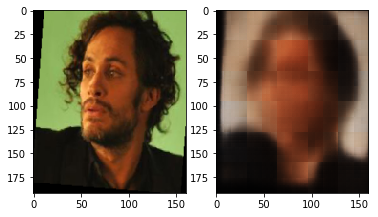

	Epoch 0 batch 3000 loss: 0.011949245817959309
	Epoch 0 batch 4000 loss: 0.00991261750459671


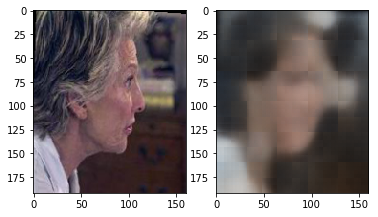

	Epoch 0 batch 5000 loss: 0.009812895208597183
	Epoch 0 batch 6000 loss: 0.008713651448488235


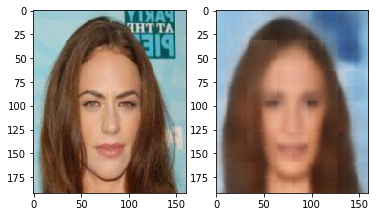

	Epoch 0 batch 7000 loss: 0.007898111827671528
	Epoch 0 batch 8000 loss: 0.008220059797167778


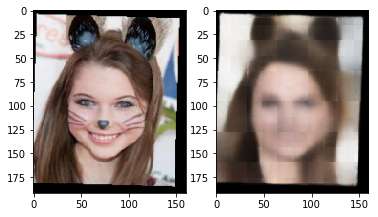

Epoch: 0 Loss: 102.26282336609438


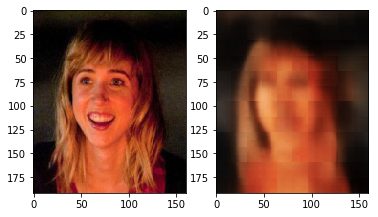

	Epoch 1 batch 1000 loss: 0.007207128219306469
	Epoch 1 batch 2000 loss: 0.007227953057736158


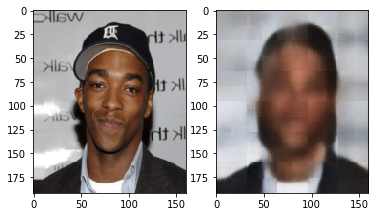

	Epoch 1 batch 3000 loss: 0.006168035790324211
	Epoch 1 batch 4000 loss: 0.006104371976107359


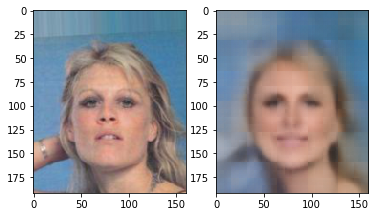

	Epoch 1 batch 5000 loss: 0.005832691211253405
	Epoch 1 batch 6000 loss: 0.005381327588111162


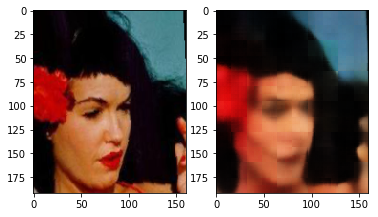

	Epoch 1 batch 7000 loss: 0.005926977377384901
	Epoch 1 batch 8000 loss: 0.00583690544590354


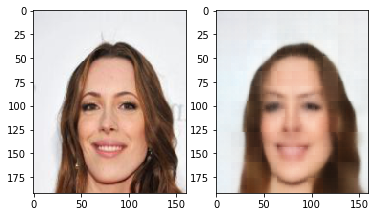

Epoch: 1 Loss: 53.51875047199428


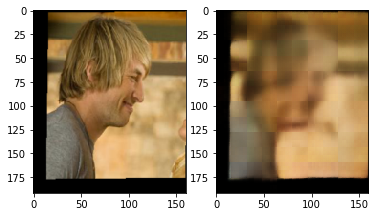

	Epoch 2 batch 1000 loss: 0.005710702855139971
Interrupting... Saving model...
Copying file://model_3.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

-
Operation completed over 1 objects/294.9 MiB.                                    


In [0]:
train(model, train_loader, optimizer, print_metrics=1000, plot_images=2000, num_epochs=3, display_images=1, scheduler=scheduler, save_path="model_3.pt")

	Epoch 0 batch 1000 loss: 0.005040746182203293
	Epoch 0 batch 2000 loss: 0.005103739444166422
	Epoch 0 batch 3000 loss: 0.004781976342201233


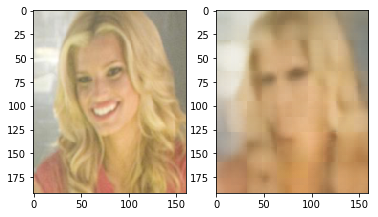

	Epoch 0 batch 4000 loss: 0.005203759763389826
	Epoch 0 batch 5000 loss: 0.0047131790779531
	Epoch 0 batch 6000 loss: 0.00460808165371418


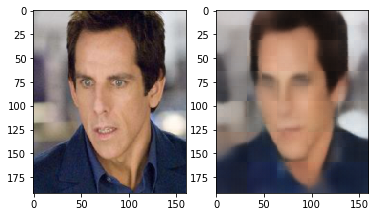

	Epoch 0 batch 7000 loss: 0.004517463501542807
	Epoch 0 batch 8000 loss: 0.0043225414119660854
Epoch: 0 Loss: 40.83976357639767


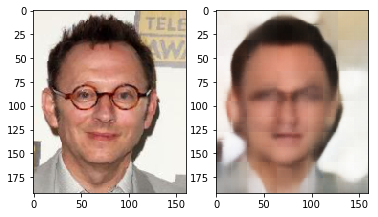

	Epoch 1 batch 1000 loss: 0.0039588878862559795
	Epoch 1 batch 2000 loss: 0.00465892069041729
	Epoch 1 batch 3000 loss: 0.004427705891430378


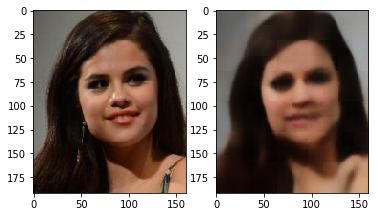

	Epoch 1 batch 4000 loss: 0.004829903598874807
	Epoch 1 batch 5000 loss: 0.004744081292301416
	Epoch 1 batch 6000 loss: 0.004044737666845322


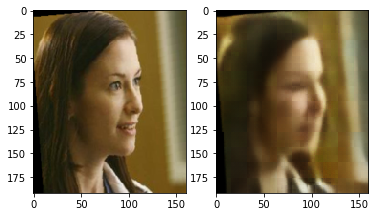

	Epoch 1 batch 7000 loss: 0.004094566218554974
	Epoch 1 batch 8000 loss: 0.004480183124542236
Epoch: 1 Loss: 35.97880330425687


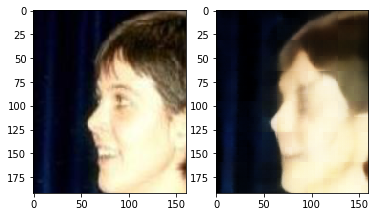

	Epoch 2 batch 1000 loss: 0.0037454101257026196


In [0]:
train(model, train_loader, optimizer, print_metrics=1000, plot_images=3000, num_epochs=3, display_images=1, scheduler=scheduler, save_path="model_3.pt")

	Epoch 1 batch 1000 loss: 0.0034045923966914415
	Epoch 1 batch 2000 loss: 0.003942681010812521
	Epoch 1 batch 3000 loss: 0.003520515514537692


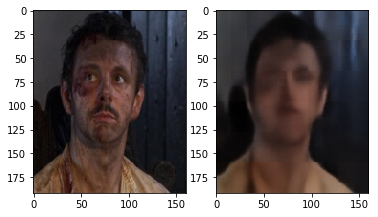

	Epoch 1 batch 4000 loss: 0.0036553237587213516
	Epoch 1 batch 5000 loss: 0.0037778071127831936
	Epoch 1 batch 6000 loss: 0.003713908838108182


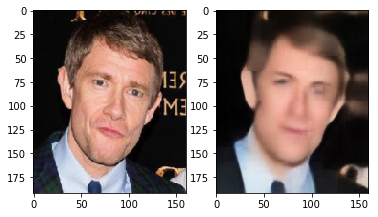

	Epoch 1 batch 7000 loss: 0.003852803958579898
	Epoch 1 batch 8000 loss: 0.003544246545061469
Epoch: 1 Loss: 30.246822604211047


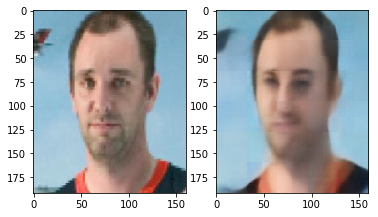

	Epoch 2 batch 1000 loss: 0.0036278804764151573
	Epoch 2 batch 2000 loss: 0.003238068427890539
	Epoch 2 batch 3000 loss: 0.0033669820986688137


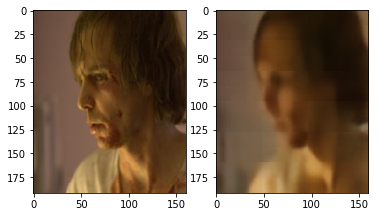

	Epoch 2 batch 4000 loss: 0.003291134024038911
	Epoch 2 batch 5000 loss: 0.003814856056123972
	Epoch 2 batch 6000 loss: 0.0038891611620783806


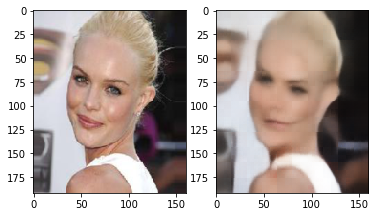

	Epoch 2 batch 7000 loss: 0.0029729059897363186
	Epoch 2 batch 8000 loss: 0.0031989270355552435
Epoch: 2 Loss: 28.650030692806467


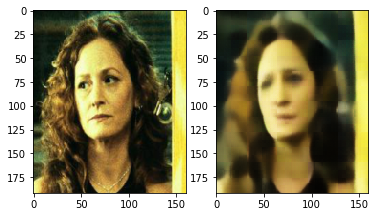

	Epoch 3 batch 1000 loss: 0.0031273062340915203
	Epoch 3 batch 2000 loss: 0.003315916284918785
	Epoch 3 batch 3000 loss: 0.0034951777197420597


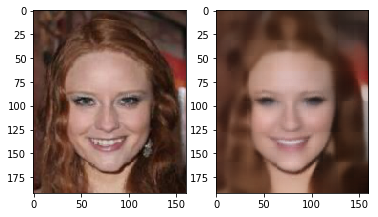

	Epoch 3 batch 4000 loss: 0.003506207372993231
	Epoch 3 batch 5000 loss: 0.003432494355365634
	Epoch 3 batch 6000 loss: 0.00307630212046206


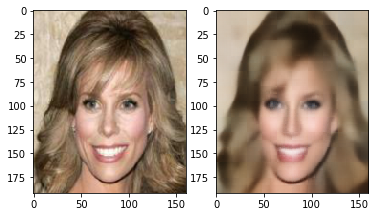

	Epoch 3 batch 7000 loss: 0.0032703743781894445
	Epoch 3 batch 8000 loss: 0.0036606306675821543
Epoch: 3 Loss: 27.376913447631523


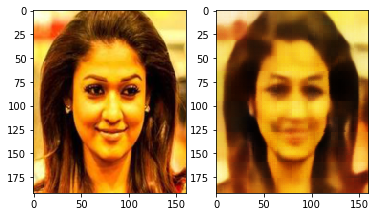

Copying file://model_3.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

-
Operation completed over 1 objects/294.9 MiB.                                    


In [0]:
train(model, train_loader, optimizer, print_metrics=1000, plot_images=3000, num_epochs=3, display_images=1, scheduler=scheduler, save_path="model_3.pt")

	Epoch 0 batch 1000 loss: 0.003217720426619053
	Epoch 0 batch 2000 loss: 0.003342887619510293
	Epoch 0 batch 3000 loss: 0.0032223740126937628


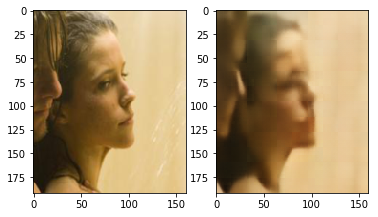

	Epoch 0 batch 4000 loss: 0.00324557744897902
	Epoch 0 batch 5000 loss: 0.003130249911919236
	Epoch 0 batch 6000 loss: 0.0036011086776852608


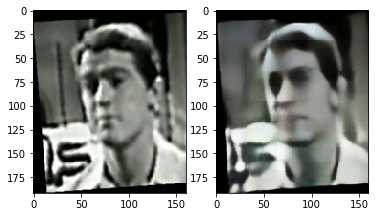

	Epoch 0 batch 7000 loss: 0.002935529686510563
	Epoch 0 batch 8000 loss: 0.0031157215125858784
Epoch: 0 Loss: 26.323966632364318


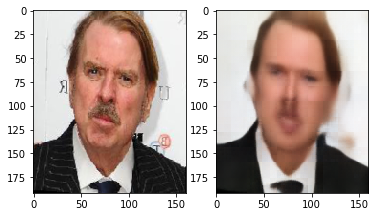

	Epoch 1 batch 1000 loss: 0.0033611059188842773
	Epoch 1 batch 2000 loss: 0.0032675140537321568
	Epoch 1 batch 3000 loss: 0.002858506515622139


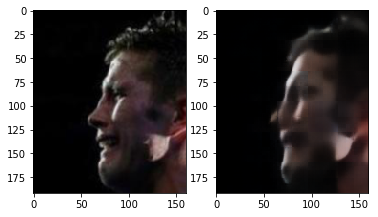

	Epoch 1 batch 4000 loss: 0.0027454043738543987
	Epoch 1 batch 5000 loss: 0.003046807600185275
	Epoch 1 batch 6000 loss: 0.002675481140613556


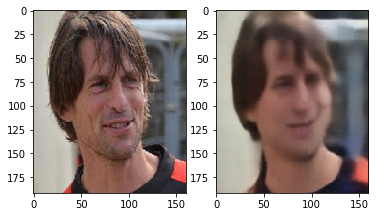

	Epoch 1 batch 7000 loss: 0.002880589570850134
	Epoch 1 batch 8000 loss: 0.0032655477989465
Epoch: 1 Loss: 25.434578981483355


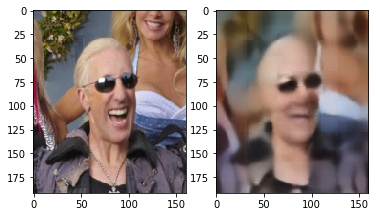

	Epoch 2 batch 1000 loss: 0.0028052758425474167
	Epoch 2 batch 2000 loss: 0.002765357494354248
	Epoch 2 batch 3000 loss: 0.00294707203283906


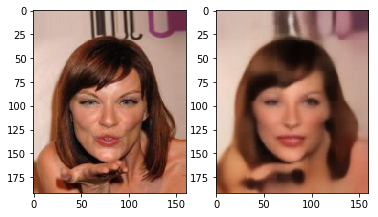

	Epoch 2 batch 4000 loss: 0.003351352410390973
	Epoch 2 batch 5000 loss: 0.0026868083514273167
	Epoch 2 batch 6000 loss: 0.0028079813346266747


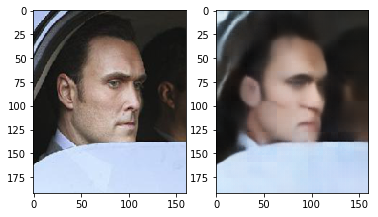

	Epoch 2 batch 7000 loss: 0.002716290531679988
	Epoch 2 batch 8000 loss: 0.003218666184693575
Epoch: 2 Loss: 24.63467610371299


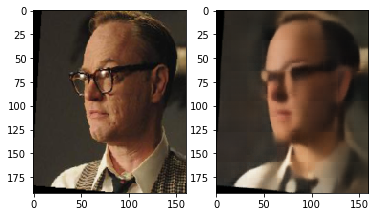

Copying file://model_3.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

-
Operation completed over 1 objects/294.9 MiB.                                    


In [0]:
train(model, train_loader, optimizer, print_metrics=1000, plot_images=3000, num_epochs=3, display_images=1, scheduler=scheduler, save_path="model_3.pt")

	Epoch 3 batch 1000 loss: 0.0026566791348159313
	Epoch 3 batch 2000 loss: 0.002870570169761777
	Epoch 3 batch 3000 loss: 0.0030622314661741257


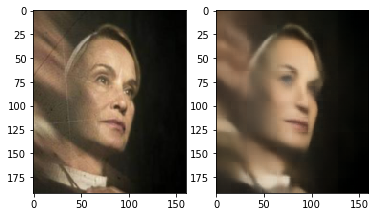

	Epoch 3 batch 4000 loss: 0.0030412538908421993
	Epoch 3 batch 5000 loss: 0.0029362025670707226
	Epoch 3 batch 6000 loss: 0.0028824538458138704


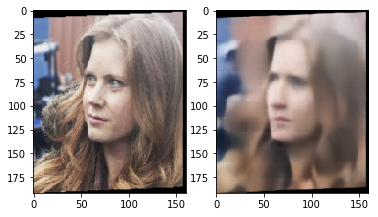

	Epoch 3 batch 7000 loss: 0.003468472044914961
	Epoch 3 batch 8000 loss: 0.0028447865042835474
Epoch: 3 Loss: 23.95191014953889


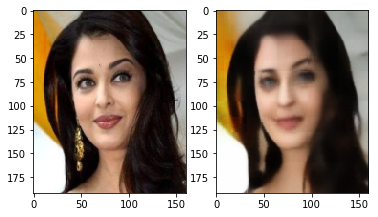

	Epoch 4 batch 1000 loss: 0.002594531513750553
	Epoch 4 batch 2000 loss: 0.0028645070269703865
	Epoch 4 batch 3000 loss: 0.002499994821846485


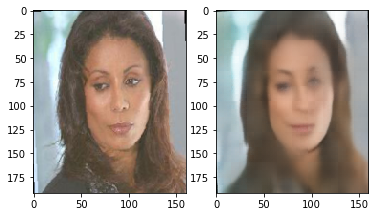

	Epoch 4 batch 4000 loss: 0.002725545084103942
	Epoch 4 batch 5000 loss: 0.0026067011058330536
	Epoch 4 batch 6000 loss: 0.002701124409213662


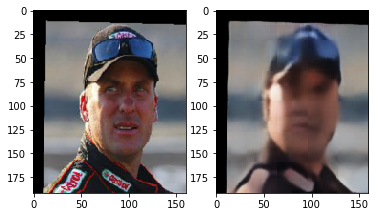

	Epoch 4 batch 7000 loss: 0.0030260870698839426
	Epoch 4 batch 8000 loss: 0.0028433797415345907
Epoch: 4 Loss: 23.35735035385005


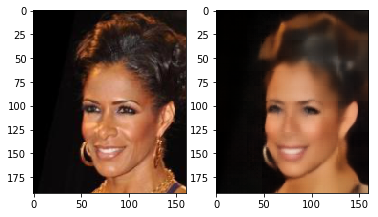

	Epoch 5 batch 1000 loss: 0.002844729460775852
	Epoch 5 batch 2000 loss: 0.0032275901176035404
	Epoch 5 batch 3000 loss: 0.0026266276836395264


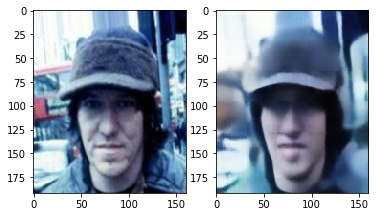

	Epoch 5 batch 4000 loss: 0.002736507449299097
	Epoch 5 batch 5000 loss: 0.002863267669454217
	Epoch 5 batch 6000 loss: 0.002851120661944151


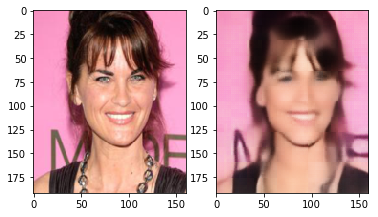

	Epoch 5 batch 7000 loss: 0.0025937138125300407
	Epoch 5 batch 8000 loss: 0.0031651854515075684
Epoch: 5 Loss: 22.794727332657203


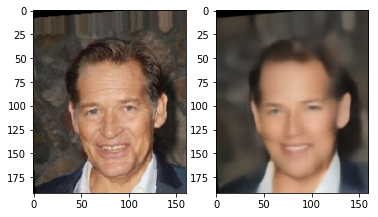

Copying file://model_3.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

-
Operation completed over 1 objects/294.9 MiB.                                    


In [0]:
train(model, train_loader, optimizer, print_metrics=1000, plot_images=3000, num_epochs=3, display_images=1, scheduler=scheduler, save_path="model_3.pt")

In [0]:
train(model, train_loader, optimizer, print_metrics=1000, plot_images=4000, num_epochs=3, display_images=1, scheduler=scheduler)

	Epoch 0 batch 1000 loss: 0.0025456983130425215
	Epoch 0 batch 2000 loss: 0.00274693057872355


In [0]:
train(model, train_loader, optimizer, print_metrics=1000, plot_images=4000, num_epochs=3, display_images=1, scheduler=scheduler)

In [0]:
noise = np.random.normal(loc=0.3, scale=7.5, size=4096).reshape((1,4096,1,1))
image = model.decoder(torch.from_numpy(noise).cuda().float())
plt.imshow(image[0].cpu().detach().permute(1,2,0))
plt.show()

In [0]:
# # download and unzip the data
# url = "https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/GWB_64x64.zip"
# if not os.path.exists("gwb_images.zip"):
#   wget.download(url, 'gwb_images.zip')

#   zip_ref = zipfile.ZipFile('gwb_images.zip', 'r')
#   zip_ref.extractall('data/gwb')
#   zip_ref.close()

In [0]:
# use the existing encoder to create a GWBush decoder
from torch import optim
import numpy as np

  ## YOUR CODE HERE ##
encoder = model.encoder
gwb_decoder = Decoder(2048)
gwb_model = SingleModel(encoder, gwb_decoder)
gwb_params = gwb_model.decoder.parameters()

# run on GPU
use_cuda = True

if use_cuda and torch.cuda.is_available():
    encoder.cuda()
    gwb_decoder.cuda()
    gwb_model.cuda()
    
optimizer = optim.Adam(gwb_params, lr=0.002)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)    

In [0]:
# gwb dataset
BATCH_SIZE = 64
data_path = "data/gwb"

transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5), 
      torchvision.transforms.RandomChoice([
        torchvision.transforms.RandomAffine(degrees=7, translate=(0.05,0.05), scale=(0.9,1.1), shear=3, resample=False, fillcolor=0),
        torchvision.transforms.RandomResizedCrop((192,160), scale=(0.90, 1.1)),
      ]),
    torchvision.transforms.ToTensor(),
    ])

gwb_train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transform
    )

gwb_train_loader2 = torch.utils.data.DataLoader(
    gwb_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [0]:
for (images, _) in gwb_train_loader2:
  plt.imshow(images[0].permute(1,2,0))
  break

In [0]:
train(gwb_model, gwb_train_loader2, optimizer, print_metrics=0, num_epochs=200, display_images=20, scheduler=scheduler, save_path="./gwb_model.pt")